<a href="https://colab.research.google.com/github/isabella-as/Intelligent-Systems-Assignments/blob/main/ANFIS_Classification_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ANFIS Approach (Task 4)**

In [55]:
pip install scikit-fuzzy

In [56]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


Here the classification problem dataset is loaded. The code fetches the Pima Indians Diabetes dataset, which contains eight clinical features per patient. The target column is mapped from the original labels (“tested_negative” and “tested_positive”) to binary values 0 and 1 for classification. The feature matrix "X" is converted to floats, and calling "X.shape" confirms its dimensions.


In [57]:
# Classification Dataset

from sklearn.datasets import fetch_openml
diabetes = fetch_openml("diabetes", version=1, as_frame=True)

X = diabetes.data.values.astype(float)
y = diabetes.target.map({'tested_negative': 0, 'tested_positive': 1}).astype(int).values
X.shape

(768, 8)

The dataset is split into training and testing sets in the same way as in Task 2, with 80% used for training and 20% for testing, with a fixed random state to make the split reproducible.

In [58]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

The features are standardized just as in Task 2.

In [59]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


Unlike in regression problems, the target is not concatenated because the labels are categorical (0/1), clustering should be done only in feature space for classification. We set two clusters and the standard fuzzifier (m=2), transpose the data to the (features, samples) shape required by "skfuzzy", and obtain the cluster centers, membership matrix, and the FPC.



In [60]:
 # Number of clusters
n_clusters = 2
m=2

# Training set of input features
Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [61]:
centers.shape

(2, 8)

The spreads of the Gaussian membership functions are computed in the same way as in Task 2. For each cluster, the membership values are used as weights to calculate the variance of every feature around its center. Taking the square root gives the sigma values, which set the width of the Gaussian functions. Since the target was not concatenated for this task, these spreads are calculated only over the eight input features.


In [62]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

The samples are assigned to the cluster with the highest membership and the FPC value is printed to summarize clustering quality. A scatter plot of the first two features is shown, with point transparency proportional to membership degree. This gives a quick visual of how the fuzzy c-means algorithm divided the data and how strongly each sample belongs to its cluster.


Fuzzy partition coefficient (FPC): 0.5000043134919435


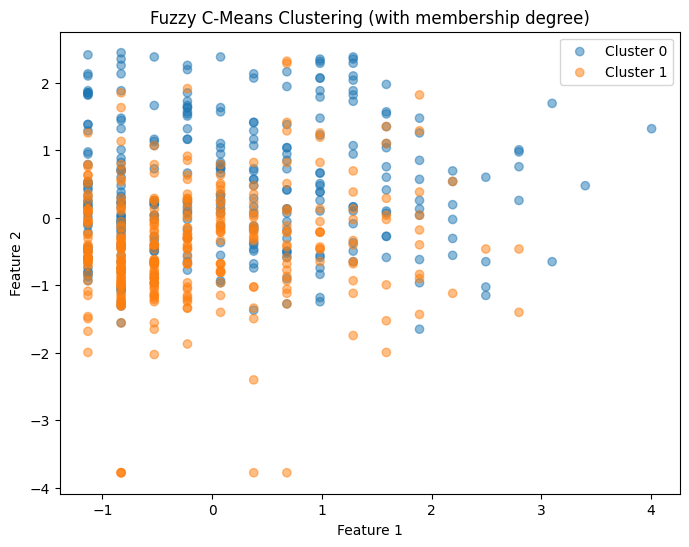

In [63]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

This plot shows the hard cluster assignments from fuzzy c-means using the first two features. Each point is colored by its assigned cluster, giving a crisp view of how the data is separated.


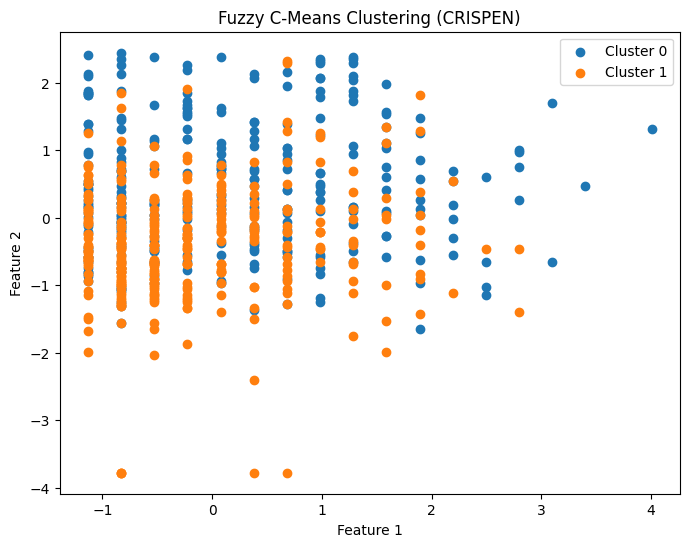

In [64]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

This code defines the Gaussian function and plots the membership curves for the first feature. Each cluster’s center and spread are used to draw its Gaussian, showing how the fuzzy sets cover that feature after standardization.


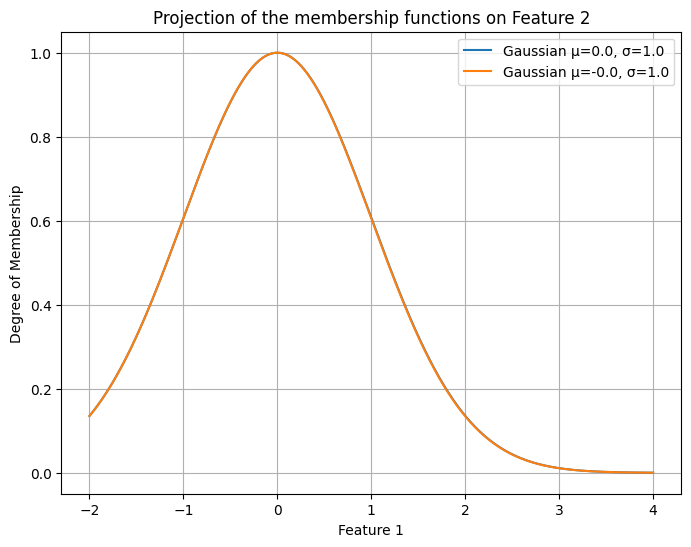

In [65]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

This part defines the fuzzy model, with "GaussianMF" creating membership functions from the cluster centers and spreads, and "TSK" combining them with linear consequents to produce predictions. It is the same structure used in Task 2.


In [66]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)

        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)

        self.mfs=GaussianMF(centers, sigmas,agg_prob)

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]

        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)

        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True)
         + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents) #(batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



This funtion works like in Task 2.

In [67]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)

        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)

        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y

        theta= torch.linalg.lstsq(Phi, y).solution


        model.consequents.data = theta.reshape(model.consequents.shape)


This function trains the TSK model using gradient descent for a classification problem. The Adam optimizer is used to adjust the model’s parameters with the chosen learning rate, while the loss is calculated with binary cross-entropy (BCEWithLogitsLoss) which is designed for binary classification. During each training epoch, the model makes predictions on the input data, the loss is computed, backpropagation calculates how the parameters should change, and the optimizer updates them to reduce the error. The loss is printed at each step to show how training is progressing.

In [68]:
# ---------------------------
# Gradient Descent Training
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()


In [69]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True


Here the TSK model is built with the number of inputs set from the feature dimension and the number of rules equal to the clusters found earlier. Unlike Task 2, the centers and sigmas are used directly without slicing, since the target was not concatenated during clustering. The training and test sets are then converted into PyTorch tensors for use with the model.


In [70]:
# Build model (classification: features only)
model = TSK(
    n_inputs=Xtr.shape[1],
    n_rules=n_clusters,
    centers=centers,
    sigmas=sigmas,
    agg_prob=False
)


Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

The model is trained such as in task 2.

In [71]:
# Training with ANFIS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))


tensor(0.6961, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6856, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6770, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6693, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6624, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6563, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6509, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6462, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6419, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6341, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6307, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6276, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6247, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6219, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6193, grad_fn=<BinaryCrossEntro

The test data is passed through the model and the outputs are thresholded at 0.5 to obtain predicted labels. These predictions are compared with the true labels to calculate and display the classification accuracy. The model reaches an accuracy of about 0.77, which means it correctly classifies roughly 77% which leaves room for improvement.



In [72]:
y_pred, _, _=model(Xte)
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}')

ACC:0.8051948051948052
